# Homework 7

## APMTH 207: Stochastic Methods for Data Analysis, Inference and Optimization

**Due Date: ** Friday, March 23rd, 2018 at 11:00am

**Instructions:**

- Upload your final answers as a Jupyter notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy
import time

import pymc3 as pm

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context('talk')
%matplotlib inline

## Problem 1: Gibbs Sampling On A Bivariate Normal

Let $\mathbf{X}$ be a random variable taking values in $\mathbb{R}^2$. That is, $\mathbf{X}$ is a 2-dimensional vector. Suppose that $\mathbf{X}$ is normally distributed as follows
$$ 
\mathbf{X} \sim \mathcal{N} \left(  
\left[
\begin{array}{c}
    1  \\ 
    2  \\ 
  \end{array} 
\right],
\left[
  \begin{array}{ccc}
    4 & 1.2  \\ 
    1.2 & 4 \\ 
  \end{array} 
  \right] \right).
$$ 
That is, the pdf of the distribution of $\mathbf{X}$ is
$$
f_{\mathbf{X}}(\mathbf{x}) = \frac{1}{2\pi\sqrt{\vert \Sigma\vert }}\mathrm{exp}\left\{ - \frac{1}{2} (\mathbf{x} - \mu)^\top \Sigma^{-1} (\mathbf{x} - \mu)\right\}
$$
where $\mu = \left[
\begin{array}{c}
    1  \\ 
    2  \\ 
  \end{array} 
\right]$, $\Sigma = \left[
  \begin{array}{ccc}
    4 & 1.2  \\ 
    1.2 & 4 \\ 
  \end{array} 
  \right]$, and $\vert \cdot\vert $ is the matrix determinant operator.

In the following, we will denote the random variable corresponding to the first component of $\mathbf{X}$ by $X_1$ and the second component by $X_2$.

* Write a Gibbs sampler for this distribution by sampling sequentially from the two conditional distributions $f_{X_1\vert X_2}, f_{X_2\vert X_1}$. 
* Choose a thinning parameter, burn-in factor and total number of iterations that allow you to take 10000 non-autocorrelated draws. 
* You must justify your choice of parameters. 

### Answer to Problem 1

Here we have $\sigma_{1} = 2$, $\sigma_{2} = 2$, $\rho = 0.3$.

At each iteration, we can sample from the conditionals
$$X_{1}\mid X_{2}=x_{2}\ \sim \ {\mathcal {N}}\left(\mu _{1}+{\frac {\sigma _{1}}{\sigma _{2}}}\rho (x_{2}-\mu _{2}),\,(1-\rho ^{2})\sigma _{1}^{2}\right)$$
$$X_{2}\mid X_{1}=x_{1}\ \sim \ {\mathcal {N}}\left(\mu _{2}+{\frac {\sigma _{2}}{\sigma _{1}}}\rho (x_{1}-\mu _{1}),\,(1-\rho ^{2})\sigma _{2}^{2}\right)$$

In [2]:
def corrplot(trace, maxlags=50):
    plt.acorr(trace-np.mean(trace),  normed=True, maxlags=maxlags);
    plt.xlim([0, maxlags])

def effective_sample_size(data, step=1):
    
    # References:
    # https://code.google.com/p/biopy/source/browse/trunk/biopy/bayesianStats.py?r=67
    # https://am207.github.io/2018spring/wiki/tetchygibbs.html
    
    n = len(data)
    assert n > 1
    maxlags = min(n//3, 1000)
    
    gamma_stat = [0, ] * maxlags
    
    var_stat = 0.0
    
    if type(data) != np.ndarray:
        data = np.array(data)
        
    data_normed = data - data.mean()
    
    for lag in range(maxlags):
        v1 = data_normed[:n-lag]
        v2 = data_normed[lag:]
        v = v1 * v2
        gamma_stat[lag] = sum(v) / len(v)
        
        if lag == 0:
            var_stat = gamma_stat[0]
        elif lag % 2 == 0:
            s = gamma_stat[lag-1] + gamma_stat[lag]
            if s > 0:
                var_stat += 2 * s
            else:
                break
                
    act = step * var_stat / gamma_stat[0]
    ess = step * n / act
    
    return ess
    
def print_ess(data):
    ess1 = effective_sample_size(data[:, 0])
    ess2 = effective_sample_size(data[:, 1])
    print('Effective size for x1:', ess1, ' of', len(data), 'samples; effective rate:', ess1/len(data))
    print('Effective size for x2:', ess2, ' of', len(data), 'samples; effective rate:', ess2/len(data))
    
class Gibbs:
    def __init__(self, mu1=1, mu2=2, sigma1=2, sigma2=2, rho=0.3):
        self.mu1 = mu1
        self.mu2 = mu2
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.rho = rho
        
    def run(self, n=10000, x_init=np.array([1, 2]), seed=0):
        start = time.time()
        mu1 = self.mu1
        mu2 = self.mu2
        sigma1 = self.sigma1
        sigma2 = self.sigma2
        rho = self.rho
        
        s12 = sigma1*np.sqrt(1-rho*rho)
        s21 = sigma2*np.sqrt(1-rho*rho)
        
        samples = np.empty((n+1, 2))
        samples[0] = x_init
        
        if seed is not None:
            np.random.seed(seed)
        
        for i in range(1, n, 2):
            m12 = mu1 + sigma1/sigma2*rho*(samples[i-1, 1]-mu2)
            samples[i, 0] = np.random.normal(m12, s12)
            samples[i, 1] = samples[i-1, 1]
            
            m21 = mu2 + sigma2/sigma1*rho*(samples[i, 0]-mu1)
            samples[i+1, 1] = np.random.normal(m21, s21)
            samples[i+1, 0] = samples[i, 0]
            
        self.n = n
        self.x_init = x_init
        self.samples = samples[:-1]
        self.time_ = time.time() - start
        return self
    
    def process(self, burnin=0, thin=1):
        self.burnin = burnin
        self.thin = thin
        self.samples2 = self.samples[burnin::thin]
        return self

We first try sampling 10000 samples without burnin and thining.

In [3]:
g0 = Gibbs().run()

We can plot autocorrelations and calculate effective sample sizes for $X_1$ and $X_2$.

No burnin and thining:
Effective size for x1: 4205.61094396  of 10000 samples; effective rate: 0.420561094396
Effective size for x2: 4323.20700695  of 10000 samples; effective rate: 0.432320700695


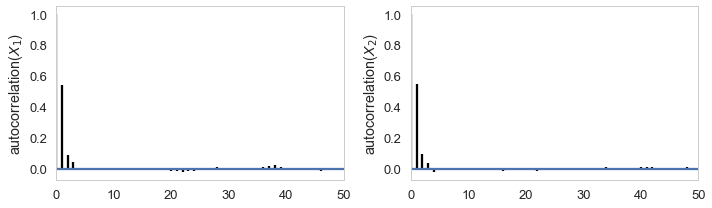

In [4]:
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
corrplot(g0.samples[:, 0])
plt.ylabel('autocorrelation($X_1$)')

plt.subplot(1, 2, 2)
corrplot(g0.samples[:, 1])
plt.ylabel('autocorrelation($X_2$)')
plt.tight_layout()

print('No burnin and thining:')
print_ess(g0.samples)

The ratio of effective sample size is around 40%. We can try thining of 3.

thining: 3
Effective size for x1: 3067.25117113  of 3334 samples; effective rate: 0.919991353068
Effective size for x2: 3006.03496452  of 3334 samples; effective rate: 0.901630163323


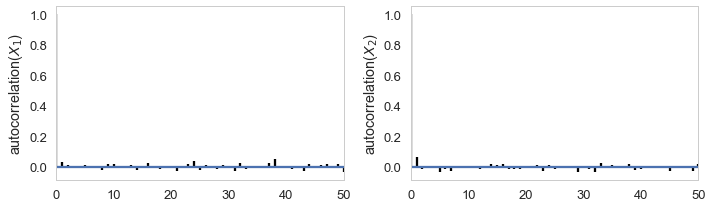

In [5]:
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
corrplot(g0.samples[::3, 0])
plt.ylabel('autocorrelation($X_1$)')

plt.subplot(1, 2, 2)
corrplot(g0.samples[::3, 1])
plt.ylabel('autocorrelation($X_2$)')
plt.tight_layout()

print('thining: 3')
print_ess(g0.samples[::3])

Effective sample sizes increase significantly. We can further increase thining to 4.

thining = 4
Effective size for x1: 2500.0  of 2500 samples; effective rate: 1.0
Effective size for x2: 2500.0  of 2500 samples; effective rate: 1.0


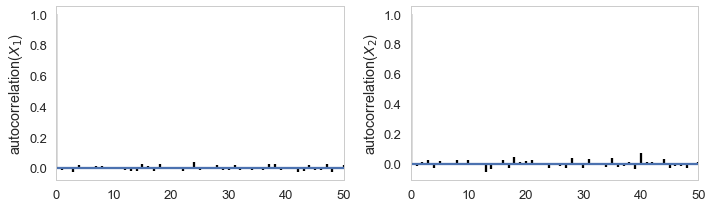

In [6]:
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
corrplot(g0.samples[::4, 0])
plt.ylabel('autocorrelation($X_1$)')

plt.subplot(1, 2, 2)
corrplot(g0.samples[::4, 1])
plt.ylabel('autocorrelation($X_2$)')
plt.tight_layout()

print('thining = 4')
print_ess(g0.samples[::4])

Effective sample size is equal to total sample size, indicating thining at 4 is a good choice.

We can take 10000 non-autocorrelated draws as follows.

In [7]:
g = Gibbs().run(n=41000).process(burnin=1000, thin=4)

Before burnin and thining:
Effective size for x1: 15626.5766006  of 41000 samples; effective rate: 0.381136014648
Effective size for x2: 17673.3582329  of 41000 samples; effective rate: 0.431057517875


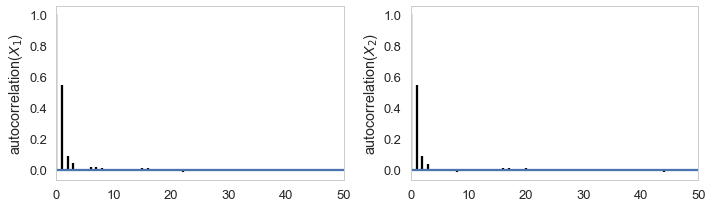

In [8]:
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
corrplot(g.samples[:, 0])
plt.ylabel('autocorrelation($X_1$)')

plt.subplot(1, 2, 2)
corrplot(g.samples[:, 1])
plt.ylabel('autocorrelation($X_2$)')
plt.tight_layout()

print('Before burnin and thining:')
print_ess(g.samples)

burnin = 1000, thining = 4:
Effective size for x1: 10000.0  of 10000 samples; effective rate: 1.0
Effective size for x2: 10000.0  of 10000 samples; effective rate: 1.0


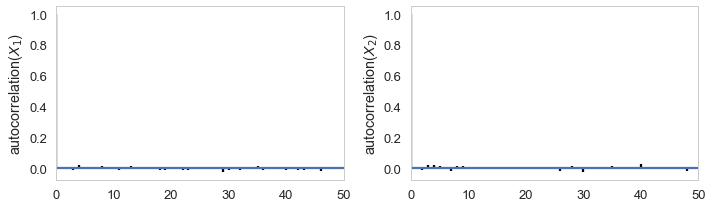

In [9]:
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
corrplot(g.samples2[:, 0])
plt.ylabel('autocorrelation($X_1$)')

plt.subplot(1, 2, 2)
corrplot(g.samples2[:, 1])
plt.ylabel('autocorrelation($X_2$)')
plt.tight_layout()

print('burnin = {}, thining = {}:'.format(g.burnin, g.thin))
print_ess(g.samples2)

As we can see, we have managed to get 10000 non-autocorrelated samples.

We can check the distribution of samples as follows.

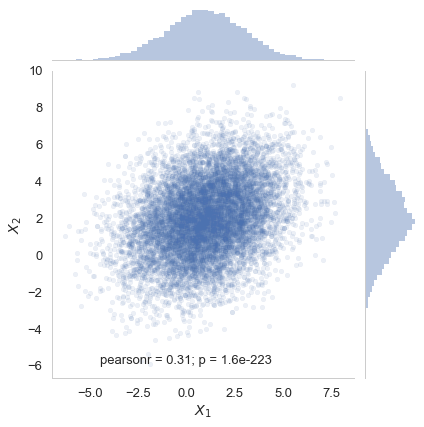

In [10]:
fig = sns.jointplot(x=0, y=1, data=pd.DataFrame(g.samples2), marker='.')
fig.ax_joint.collections[0].set_alpha(0.1);
fig.set_axis_labels('$X_1$', '$X_2$');

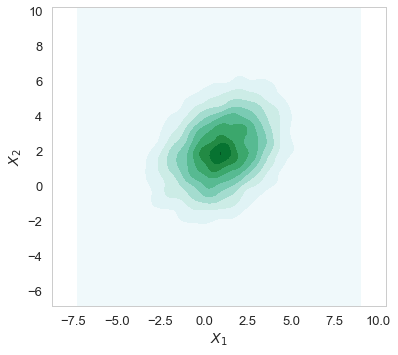

In [11]:
plt.figure(figsize=(6, 5.5))
sns.kdeplot(g.samples2[:, 0], g.samples2[:, 1], shade=True);
plt.xlabel('$X_1$');
plt.ylabel('$X_2$');
plt.axis('equal');

In [12]:
print('Sample mean: {}'.format(np.mean(g.samples2, axis=0)))
print('Sample covariance matrix:\n{}'.format(np.cov(g.samples2.T)))

Sample mean: [ 0.97814803  1.99811913]
Sample covariance matrix:
[[ 4.06716768  1.25038072]
 [ 1.25038072  3.9683216 ]]


As we can see, samples are desirable.

## Problem 2: Rubber Chickens Bawk Bawk!
In the competitive rubber chicken retail market, the success of a company is built on satisfying the exacting standards of a consumer base with refined and discriminating taste. In particular, customer product reviews are all important. But how should we judge the quality of a product based on customer reviews?

On Amazon, the first customer review statistic displayed for a product is the ***average rating***. The following are the main product pages for two competing rubber chicken products, manufactured by Lotus World and Toysmith respectively:


Lotus World |  Toysmith
- |  - 
![alt](https://am207.github.io/2018spring/homework/lotus1.png) |  ![alt](https://am207.github.io/2018spring/homework/toysmith1.png)

Clicking on the 'customer review' link on the product pages takes us to a detailed break-down of the reviews. In particular, we can now see the number of times a product is rated a given rating (between 1 and 5 stars).

Lotus World |  Toysmith
- |  - 
![alt](https://am207.github.io/2018spring/homework/lotus2.png) |  ![alt](https://am207.github.io/2018spring/homework/toysmith2.png)

(The images above are also included on canvas in case you are offline, see below)

In the following, we will ask you to compare these two products using the various rating statistics. **Larger versions of the images are available in the data set accompanying this notebook**.

Suppose that for each product, we can model the probability of the value each new rating as the following vector:
$$
\theta = [\theta_1, \theta_2, \theta_3, \theta_4, \theta_5]
$$
where $\theta_i$ is the probability that a given customer will give the product $i$ number of stars.


### Part A: Inference

1. Suppose you are told that customer opinions are very polarized in the retail world of rubber chickens, that is, most reviews will be 5 stars or 1 stars (with little middle ground). Choose an appropriate Dirichlet prior for $\theta$. Recall that the Dirichlet pdf is given by:
$$
f_{\Theta}(\theta) = \frac{1}{B(\alpha)} \prod_{i=1}^k \theta_i^{\alpha_i - 1}, \quad B(\alpha) = \frac{\prod_{i=1}^k\Gamma(\alpha_i)}{\Gamma\left(\sum_{i=1}^k\alpha_i\right)},
$$
where $\theta_i \in (0, 1)$ and $\sum_{i=1}^k \theta_i = 1$, $\alpha_i > 0 $ for $i = 1, \ldots, k$.

2. Write an expression for the posterior pdf, using a using a multinomial model for observed ratings. Recall that the multinomial pdf is given by:
$$
f_{\mathbf{X}\vert  \Theta}(\mathbf{x}) = \frac{n!}{x_1! \ldots x_k!} \theta_1^{x_1} \ldots \theta_k^{x_k}
$$
where $n$ is the total number of trials, $\theta_i$ is the probability of event $i$ and $\sum_i \theta_i = 1$, and $x_i$ is count of outcome $i$ and $\sum_i x_i = n$. 

  **Note:** The data you will need in order to define the likelihood function should be read off the image files included in the dataset.
  

3. Sample 1,000 values of $\theta$ from the *posterior distribution*.
 
4. Sample 1,000 values of $x$ from the *posterior predictive distribution*.


### Part B: Ranking

1. Name at least two major potential problems with using only the average customer ratings to compare products.

  (**Hint:** if product 1 has a higher average rating than product 2, can we conclude that product 1 is better liked? If product 1 and product 2 have the same average rating, can we conclude that they are equally good?)
  

2. Using the samples from your *posterior distribution*, determine which rubber chicken product is superior. Justify your conclusion with sample statistics.

3. Using the samples from your *posterior predictive distribution*, determine which rubber chicken product is superior. Justify your conclusion with sample statistics.

4. Finally, which rubber chicken product is superior?

  (**Note:** we're not looking for "the correct answer" here, any sound decision based on a statistically correct interpretation of your model will be fine)

### Answer to Problem 2 Part A

We can set high $\alpha_1$, $\alpha_5$ and low $\alpha_2$, $\alpha_3$, $\alpha_4$ since most reviews will be 5 stars or 1 stars. 

For example, we can set the following Dirichlet prior for $\theta$:
$$\Theta \sim {\rm Dirichlet\ (\alpha = [6, 1, 1, 1, 6])}$$

And we can check the prior distributions.

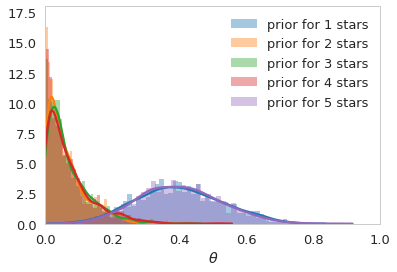

In [2]:
alpha = np.array([6, 1, 1, 1, 6])

np.random.seed(0)
prior_samples = np.random.dirichlet(alpha, size=1000)

for i in range(prior_samples.shape[1]):
    sns.distplot(prior_samples[:, i], bins=50, norm_hist=True, \
                 label='prior for {} stars'.format(i + 1));

plt.xlabel(r'$\theta$');
plt.xlim([0, 1]);
plt.ylim([0, 18]);
plt.legend();

As we can see, the prior distributions are desirable.

The posteriror for $\theta$ is 
$$p(\theta|X) \propto p(\theta)\ p(X|\theta) \propto {\rm Dirichlet}\ (\alpha)\ {\rm Multinomial}\ (\theta, X)$$
$$\therefore\ p(\theta|X) \propto \prod_{i=1}^k \theta_i^{\alpha_i + x_i - 1}$$
i.e.,
$$p(\theta|X) \propto  {\rm Dirichlet}\ (\alpha + X)$$

To sample $\theta$ from the posterior distribution, we can sample from the above distribution directly. To sample $x$ from the posterior predictive distribution, we can sample $\theta$ from the posterior distribution and then sample from the likelihood using the $\theta$.

In [3]:
n1 = 162
x1 = np.array([0.06, 0.04, 0.06, 0.17, 0.67]) * n1
n2 = 410
x2 = np.array([0.14, 0.08, 0.07, 0.11, 0.60]) * n2

data1 = {'n':n1, 'x':x1}
data2 = {'n':n2, 'x':x2}

In [4]:
class Inference:
    def __init__(self, data):
        self.n = data['n']
        self.x = data['x']
        
    def posterior(self, n_samples=1000, alpha=np.array([6, 1, 1, 1, 6]), seed=0):
        n = self.n
        x = self.x
        if seed is not None:
            np.random.seed(seed)
        self.samples = np.random.dirichlet(alpha + x, size=n_samples)
        return self
    
    def posterior_predictive(self, n_samples=1000, alpha=np.array([6, 1, 1, 1, 6]), seed=0):
        n = self.n
        x = self.x
        if seed is not None:
            np.random.seed(seed)
        samples = np.random.dirichlet(alpha + x, size=n_samples)
        self.samples2 = np.array([np.random.multinomial(self.n, samples[i]) for i in range(n_samples)])
        return self

In [5]:
post1 = Inference(data1).posterior().posterior_predictive()
post2 = Inference(data2).posterior().posterior_predictive()

### Answer to Problem 2 Part B

#### Major potential problems with using only the average customer ratings to compare products

1. The average ratings might be uninformative about the predictive power since the number of reviews is not accounted for. For example, product 1 has 2 reviews of 1 stars and 10 reviews of 5 stars, while product 2 has 200 reviews of 1 stars and 1000 reviews of 5 stars; the average ratings are the same, but the predictive power is different since there are more observations for product 2.
2. The average ratings could be sensitive to outliers, especially when the number of reviews is low.
3. The average ratings are uninformative about the variance of ratings. For example, we can draw different conclusions on the product with 500 ratings of 3 stars and 500 ratings of 4 stars and the product with 500 ratings of 2 stars and 500 ratings of 5 stars.

#### Using the samples from your posterior distribution, determine which rubber chicken product is superior

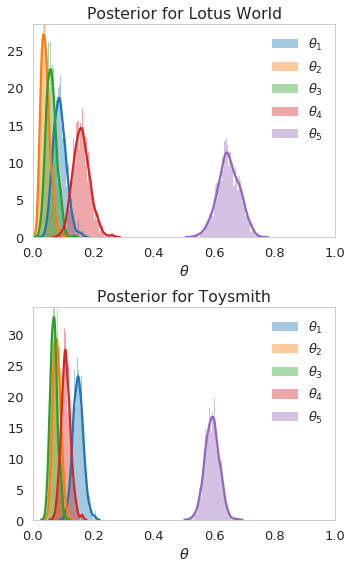

In [6]:
plt.figure(figsize=(5, 8))

plt.subplot(2, 1, 1)
for i in range(5):
    sns.distplot(post1.samples[:, i], bins=50, label=r'$\theta_{}$'.format(i + 1))
plt.xlim([0, 1]);
plt.xlabel(r'$\theta$');
plt.title('Posterior for Lotus World');
plt.legend();

plt.subplot(2, 1, 2)
for i in range(5):
    sns.distplot(post2.samples[:, i], bins=50, label=r'$\theta_{}$'.format(i + 1))
plt.xlim([0, 1]);
plt.xlabel(r'$\theta$');
plt.title('Posterior for Toysmith');
plt.legend();

plt.tight_layout();

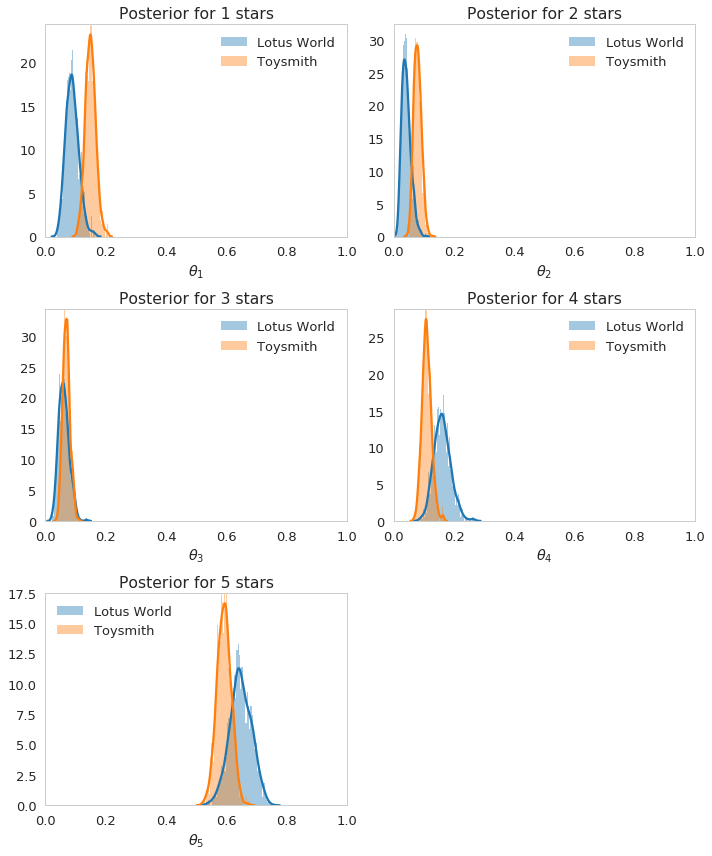

In [7]:
plt.figure(figsize=(10, 12))

for i in range(5):
    plt.subplot(3, 2, i + 1)
    sns.distplot(post1.samples[:, i], bins=50, label='Lotus World')
    sns.distplot(post2.samples[:, i], bins=50, label='Toysmith')
    plt.xlim([0, 1]);
    plt.xlabel(r'$\theta_{}$'.format(i + 1));
    plt.title('Posterior for {} stars'.format(i + 1));
    plt.legend();
    
plt.tight_layout();

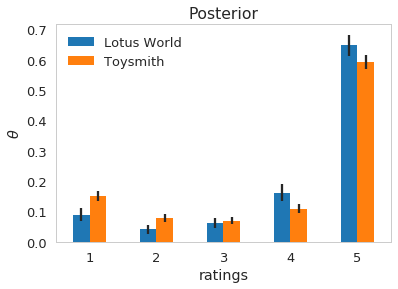

In [8]:
df21_mean = pd.DataFrame.from_items([('Lotus World', np.mean(post1.samples, axis=0)), \
                                     ('Toysmith', np.mean(post2.samples, axis=0))])
df21_std = pd.DataFrame.from_items([('Lotus World', np.std(post1.samples, axis=0)), \
                                    ('Toysmith', np.std(post2.samples, axis=0))])
df21_mean.plot.bar(yerr=df21_std);
plt.xticks(range(5), range(1, 6), rotation=0);
plt.xlabel('ratings');
plt.ylabel(r'$\theta$');
plt.title('Posterior');

According to the posterior distribution, Lotus World is superior. Posterior distributions, as well as MAP values, indicate Lotus World is more likely to recieve ratings of 4 stars or 5 stars than Toysmith does; according to posterior $\theta$, Lotus World is less likely to recieve 1 stars or 2 stars than Toysmith does.

#### Using the samples from your posterior predictive distribution, determine which rubber chicken product is superior

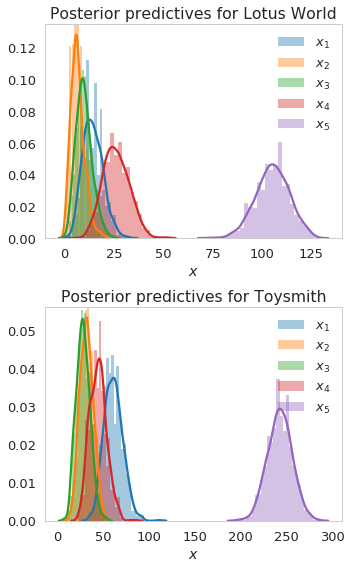

In [9]:
plt.figure(figsize=(5, 8))

plt.subplot(2, 1, 1)
for i in range(5):
    sns.distplot(post1.samples2[:, i], label=r'$x_{}$'.format(i + 1))
plt.xlabel(r'$x$');
plt.title('Posterior predictives for Lotus World');
plt.legend();

plt.subplot(2, 1, 2)
for i in range(5):
    sns.distplot(post2.samples2[:, i], label=r'$x_{}$'.format(i + 1))
plt.xlabel(r'$x$');
plt.title('Posterior predictives for Toysmith');
plt.legend(loc=1);

plt.tight_layout();

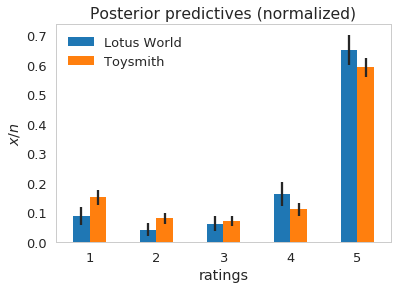

In [10]:
df22_mean = pd.DataFrame.from_items([('Lotus World', np.mean(post1.samples2, axis=0) / n1), \
                                     ('Toysmith', np.mean(post2.samples2, axis=0) / n2)])
df22_std = pd.DataFrame.from_items([('Lotus World', np.std(post1.samples2, axis=0) / n1), \
                                    ('Toysmith', np.std(post2.samples2, axis=0) / n2)])
df22_mean.plot.bar(yerr=df22_std);
plt.xticks(range(5), range(1, 6), rotation=0);
plt.xlabel('ratings');
plt.ylabel(r'$x/n$');
plt.title('Posterior predictives (normalized)');

According to the posterior predictive distribution, Lotus World is superior. There are more samples (in percentage) with ratings of 4 stars or 5 stars for Lotus World, and there are less samples (in percentage) with ratings of 1 stars or 2 stars for Lotus World.

#### Finally, which rubber chicken product is superior?

Lotus World is superior, since the average rating, posterior distribution and posterior predictive distribution all suggest Lotus World is superior.

## Problem 3:  Implementing Rat Tumors in pymc3

(it may help to see the bioassay lab to see how to structure pymc3 code, and also the examples from lecture).

Let us try to do full Bayesian inference with PyMC3 for the rat tumor example that we have solved using explicit Gibbs sampling in lab7. Remember that the goal is to estimate $\theta_i$, the probability of developing a tumor in a population of female rats that have not received treatement. 

The posterior for the 70 experiments may be written thus:

$$p( \{\theta_i\}, \alpha, \beta  \vert  Y, \{n_i\}) \propto p(\alpha, \beta) \prod_{i=1}^{70} Beta(\theta_i, \alpha, \beta) \prod_{i=1}^{70} Binom(n_i, y_i, \theta_i)$$

Use uniform priors on $[0,1]$ on the alternative variables $\mu$ (the mean of the beta distribution) and $\nu$:

$$\mu = \frac{\alpha}{\alpha+\beta}, \nu = (\alpha+\beta)^{-1/2}$$

You may then write $\alpha$ and $\beta$ as deterministics which depend on $\mu$ and $\nu$.

Here is the data:

In [20]:
tumordata="""0 20 
0 20 
0 20 
0 20 
0 20 
0 20 
0 20 
0 19 
0 19 
0 19 
0 19 
0 18 
0 18 
0 17 
1 20 
1 20 
1 20 
1 20 
1 19 
1 19 
1 18 
1 18 
3 27 
2 25 
2 24 
2 23 
2 20 
2 20 
2 20 
2 20 
2 20 
2 20 
1 10 
5 49 
2 19 
5 46 
2 17 
7 49 
7 47 
3 20 
3 20 
2 13 
9 48 
10 50 
4 20 
4 20 
4 20 
4 20 
4 20 
4 20 
4 20 
10 48 
4 19 
4 19 
4 19 
5 22 
11 46 
12 49 
5 20 
5 20 
6 23 
5 19 
6 22 
6 20 
6 20 
6 20 
16 52 
15 46 
15 47 
9 24 
"""

### Part A:  Report at least the following diagostics on your samples

1. Autocorrelation (correlation dying by lag 20 is fine)
2. Parameter trace correlation after burnin
3. Gewecke
4. Gelman-Rubin
5. $n_{eff}$ (Number of Effective Samples)

### Part B:  Posterior predictive check

Recall from lab notes that in a hierarchical model there are two kinds of posterior predictions that are useful. (1) The distribution of future observations $y_i^*$  given a $\theta_i$, and (2) The distribution of observations $y_j^*$  drawn from a future $\theta_j$ drawn from the super-population (i.e. using the Beta on the estimated hyper parameters).

1. Carry out posterior predictive checks by using `sample_ppc` to generate posterior-predictives for all 70 experiments. This generates predictives of the first type above. 

2. Plot histograms for these predictives with the actual value shown as a red-dot against the histogram (as in the coal disasters model in lecture 14). Is the data consistent with the predictive?

### Part C:  Shrinkage

1. Plot the posterior median of the death rate parameters $\theta_1, \theta_2, ...\theta_{70}$ against the observed death rates ($y_i/n_i$)

2. Explain the shrinkage by comparing against a 45 degree line as done in the lab.

### PART D:  Experiment 71

Consider an additional experiment -- experiment 71 -- in which 4 out of 14 rats died. 

1. Calculate the marginal posterior of $\theta_{71}$, the "new" experiment,

2. Find the $y_{71}^*$ posterior predictive for that experiment.

**HINT: ** The critical thing to notice is that the posterior including the 71st experiment factorizes:

$$p(\theta_{71}, \theta_{1..70}, \alpha, \beta \vert  D)  \propto p(y_{71} \vert n_{71}, \theta_{71} ) p(\theta_{71} \vert \alpha, \beta) p(\theta_{1..70}, \alpha, \beta \vert  D)$$

Then we simply marginalize over everything to get the $\theta_{71}$ posterior:

$$p(\theta_{71} \vert \theta_{1..70}, \alpha, \beta, D) = \int d\alpha \,d\beta \,d\theta_{1..70} \,p(\theta_{71}, \theta_{1..70}, \alpha, \beta \vert  D)$$

$$=  \int d\alpha \,d\beta  Beta(\alpha+y_{71}, \beta + n_{71} - y_{71})  \int_{\theta_{1..70}} \,d\theta_{1..70} \,p(\theta_{1..70}, \alpha, \beta \vert  D)$$

The $y_{71}^*$ posterior predictive can be found in the usual way.

### Answer to Problem 3

In [21]:
import pymc3 as pm
from theano import shared
from scipy import stats

In [22]:
tumortuples=[e.strip().split() for e in tumordata.split("\n")]
tumory=np.array([np.int(e[0].strip()) for e in tumortuples if len(e) > 0])
tumorn=np.array([np.int(e[1].strip()) for e in tumortuples if len(e) > 0])
tumory_shared = shared(tumory)
tumorn_shared = shared(tumorn)

In [23]:
%%time
with pm.Model() as rt:
    mu = pm.Uniform('mu', lower=0, upper=1)
    nu = pm.Uniform('nu', lower=0, upper=1)
    alpha = mu / (nu * nu)
    beta = (1 - mu) / (nu * nu)
    theta = pm.Beta('theta', alpha=alpha, beta=beta, shape=len(tumorn))
    obs = pm.Binomial('obs', n=tumorn_shared, p=theta, observed=tumory_shared)

CPU times: user 1.68 s, sys: 174 ms, total: 1.86 s
Wall time: 4.45 s


In [24]:
%%time

with rt:
    step = pm.NUTS()
    rt_traces = pm.sample(15000, tune=5000, step=step, njobs=4)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_logodds__, nu_interval__, mu_interval__]
100%|██████████| 20000/20000 [02:39<00:00, 125.20it/s]
The number of effective samples is smaller than 25% for some parameters.


CPU times: user 6.62 s, sys: 3.05 s, total: 9.67 s
Wall time: 3min 5s


### Answer to Problem 3 Part A

#### Autocorrelation

CPU times: user 1min 9s, sys: 625 ms, total: 1min 10s
Wall time: 1min 10s


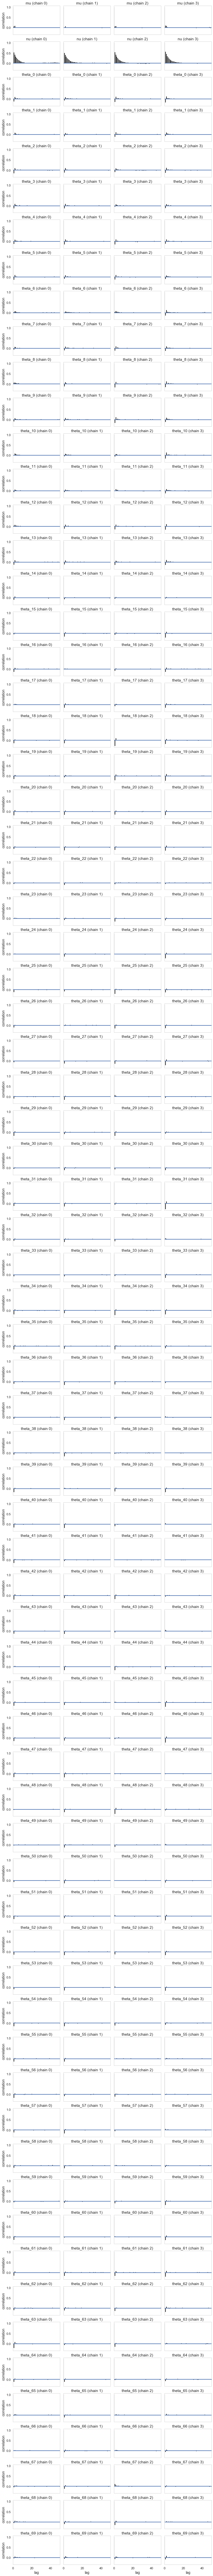

In [25]:
%%time
pm.autocorrplot(rt_traces, max_lag=50);
plt.tight_layout();
0;

Autocorrelations are dying very quickly (no more than lag 20) for all parameters in all chains.

#### Parameter trace correlation

We have set `tune` to be 5000 in our sampler, and we don't manually burnin here.

CPU times: user 2.17 s, sys: 103 ms, total: 2.27 s
Wall time: 2.29 s


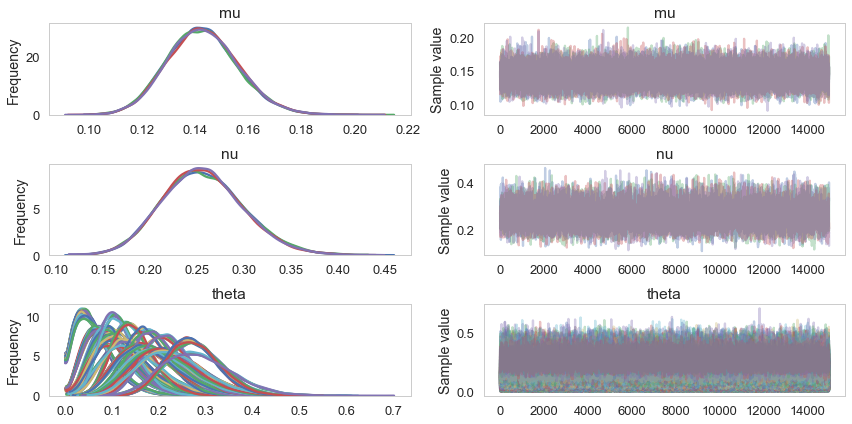

In [26]:
%%time
pm.traceplot(rt_traces);
0;

Traces in different chains are consistent, and traces look like white noises. The result indicates the convergence of parameters, and suggests that manual burnin might not be necessary when we set `tune` to be 5000 in our sampler.

#### Gewecke

In [27]:
z = pm.geweke(rt_traces, intervals=10)

CPU times: user 20.3 s, sys: 372 ms, total: 20.6 s
Wall time: 21.2 s


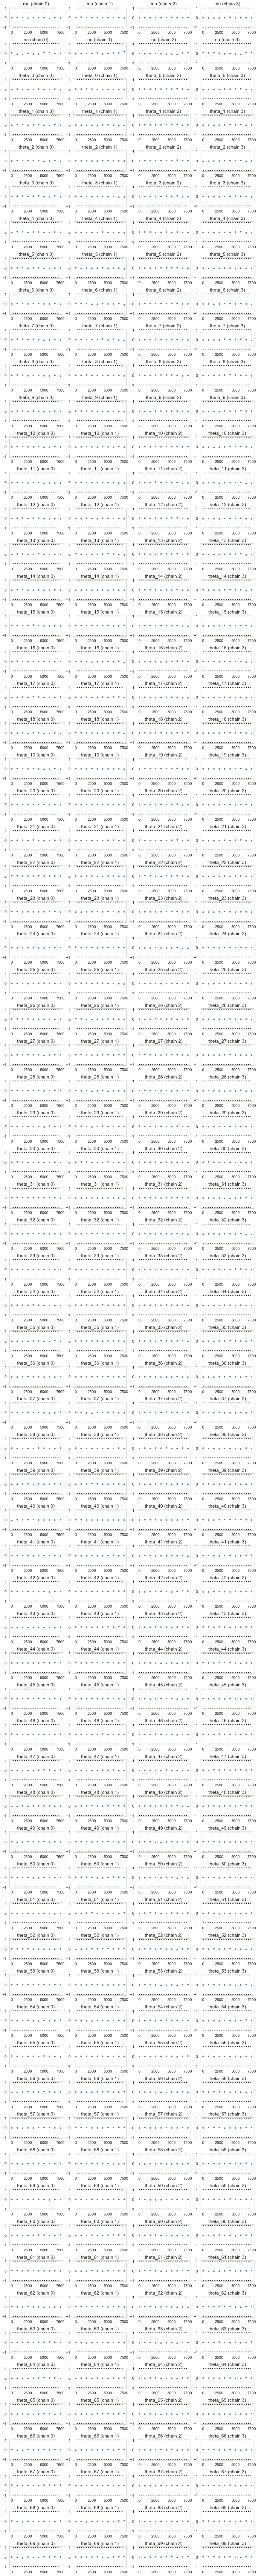

In [28]:
%%time

xlim = [0, 7500]
plt.figure(figsize=(12, 120))

for i in range(4):
    plt.subplot(72, 4, i+1)
    plt.scatter(*z[i]['mu'].T, marker='.');
    plt.hlines([-1,1], xlim[0], xlim[1], linestyles='dotted');
    plt.title('mu (chain {})'.format(i))
    
    plt.subplot(72, 4, i+5)
    plt.scatter(*z[i]['nu'].T, marker='.');
    plt.hlines([-1,1], xlim[0], xlim[1], linestyles='dotted');
    plt.title('nu (chain {})'.format(i))

    for j in range(70):
        plt.subplot(72, 4, i+1+(j+2)*4)
        plt.scatter(*z[i]['theta'][j].T, marker='.');
        plt.hlines([-1,1], xlim[0], xlim[1], linestyles='dotted');
        plt.title('theta_{} (chain {})'.format(j, i))
    
plt.tight_layout();

As we can see, z-scores are very close to 0 for all parameters in all chains, which provides evdidence for convergence.

#### Gelman-Rubin

In [29]:
print('Gelman-Rubin')
print(pm.gelman_rubin(rt_traces))

Gelman-Rubin
{'mu': 1.0000118789100012, 'nu': 1.0001469173525572, 'theta': array([ 1.00002388,  1.00013718,  0.99998991,  0.99999054,  1.00000355,
        0.99999978,  1.00019411,  1.0000001 ,  0.99998078,  0.99997899,
        1.00004545,  1.00000005,  1.00002517,  0.99998863,  0.99999716,
        0.99999443,  1.00001438,  1.0000121 ,  1.00002324,  0.99997463,
        0.99997049,  0.99998148,  1.00000938,  1.00006749,  1.00000855,
        0.99999168,  1.00000735,  1.00003083,  1.00006382,  1.00005009,
        0.99998443,  1.00000095,  0.99999327,  0.9999991 ,  0.99997096,
        1.00003026,  1.00000119,  0.99998311,  0.99999785,  0.99999862,
        1.00000541,  0.99997526,  1.00000307,  1.00005443,  0.99999717,
        0.99998313,  0.99999663,  0.9999805 ,  0.99997697,  1.00004308,
        1.00007412,  0.9999707 ,  1.00000777,  0.99997944,  0.99999125,
        0.99997607,  1.00004092,  0.99998452,  0.9999837 ,  0.99999666,
        1.00000843,  1.00001197,  1.0000111 ,  0.99999417,  0

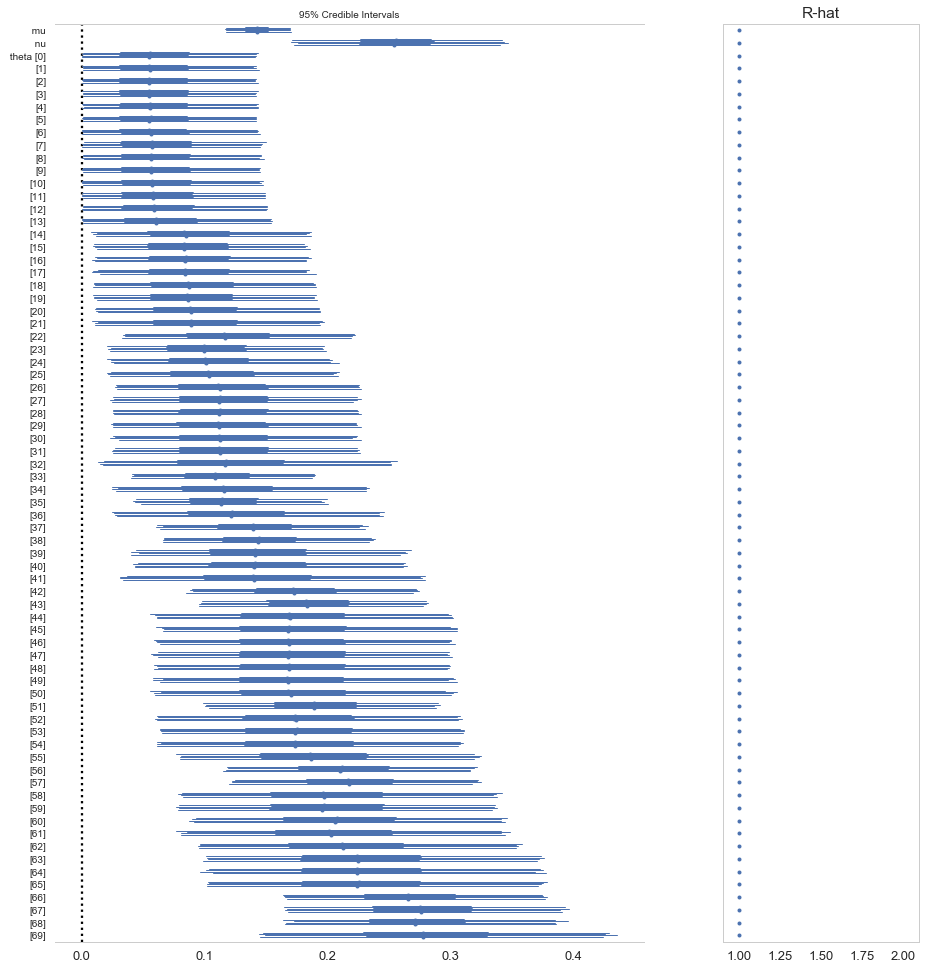

In [30]:
plt.figure(figsize=(15, 15))
pm.forestplot(rt_traces);
0;

The values of $\hat{R}$ are very close to 1 for all parameters, indicating the convergence of these parameters.

#### Number of Effective Samples ($n_{eff}$)

In [31]:
print('Effective sample sizes')
print(pm.effective_n(rt_traces))

Effective sample sizes
{'mu': 45434.0, 'nu': 9112.0, 'theta': array([ 60000.,  41929.,  60000.,  60000.,  60000.,  60000.,  38677.,
        60000.,  42279.,  60000.,  43546.,  42511.,  44862.,  60000.,
        60000.,  60000.,  60000.,  60000.,  60000.,  60000.,  60000.,
        60000.,  60000.,  60000.,  60000.,  60000.,  60000.,  60000.,
        60000.,  60000.,  60000.,  60000.,  60000.,  60000.,  60000.,
        60000.,  60000.,  60000.,  60000.,  60000.,  60000.,  60000.,
        60000.,  60000.,  60000.,  60000.,  60000.,  60000.,  60000.,
        60000.,  60000.,  60000.,  60000.,  60000.,  60000.,  60000.,
        60000.,  60000.,  60000.,  60000.,  60000.,  60000.,  60000.,
        60000.,  60000.,  50799.,  50766.,  48423.,  60000.,  60000.])}


As we can see, the number of effective samples approaches the number of samples for most parameters. The worst case is $\nu$, which still contains nearly 10k effective samples.

### Answer to Problem 3 Part B
#### 1. Carry out posterior predictive checks by using sample_ppc to generate posterior-predictives for all 70 experiments.

In [32]:
with rt:
    rt_sim = pm.sample_ppc(rt_traces, samples=10000)

100%|██████████| 10000/10000 [00:04<00:00, 2161.55it/s]


#### 2. Plot histograms for these predictives with the actual value shown as a red-dot against the histogram.

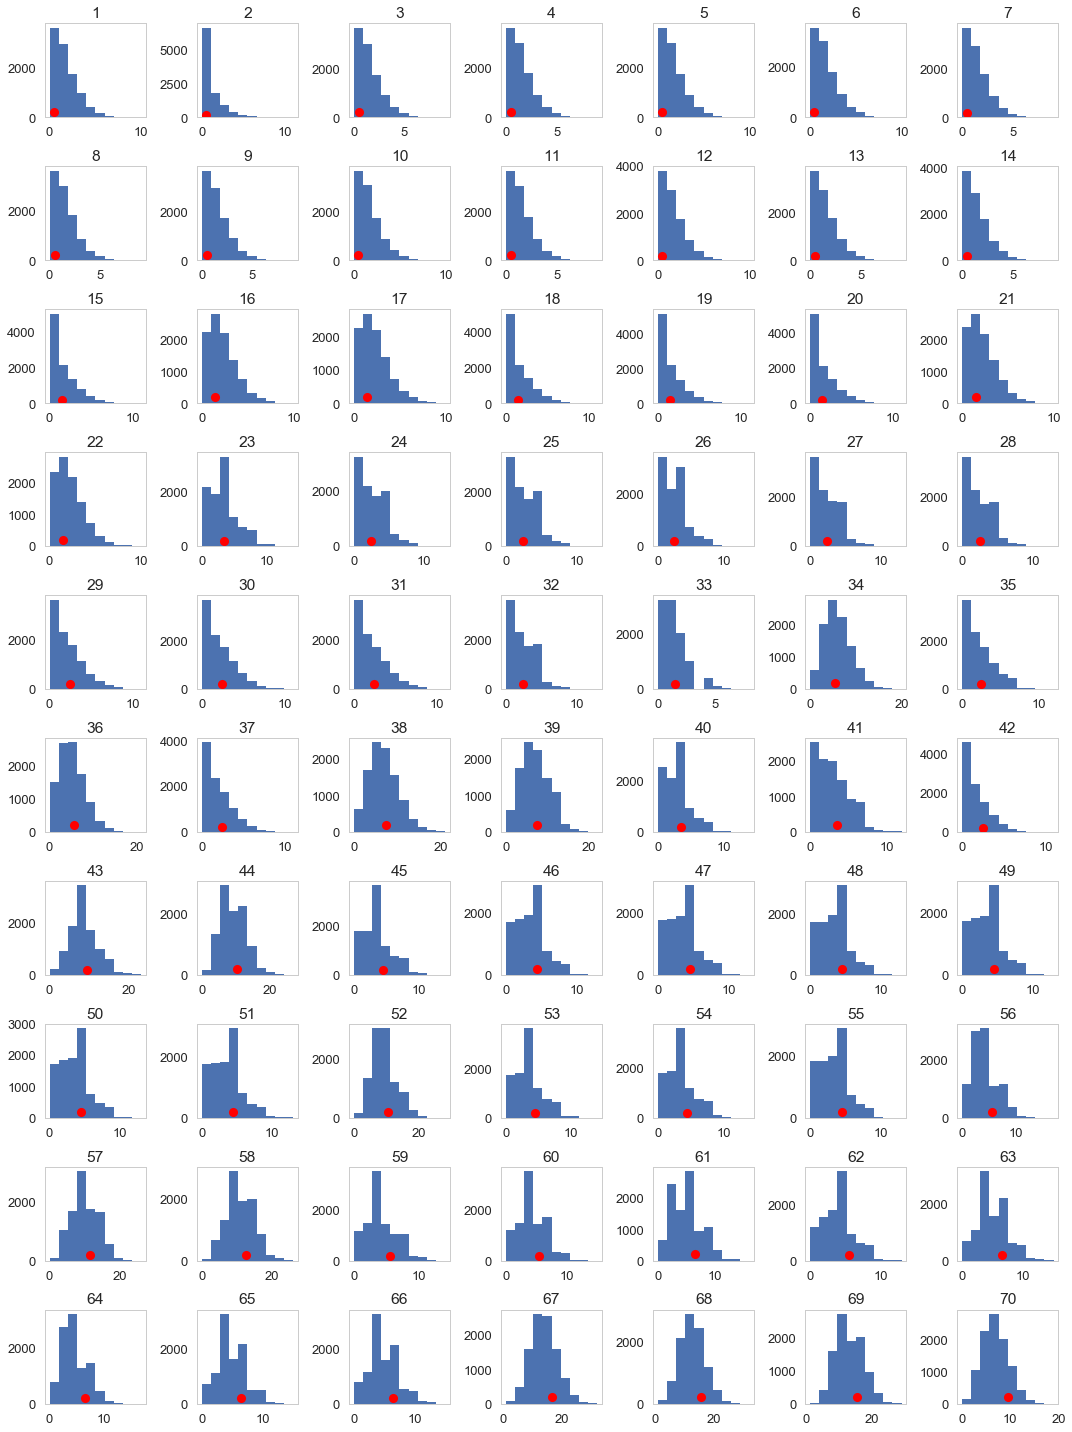

In [33]:
plt.figure(figsize=(15, 20))

for i in range(70):
    plt.subplot(10, 7, i + 1)
    plt.hist(rt_sim['obs'].T[i], bins=10);
    plt.plot(tumory[i] + 0.5, 200, 'ro');
    plt.title('{}'.format(i + 1));
plt.tight_layout();

The data is consistent with the predictive for all 70 experiments.

### Answer to Problem 3 Part C

#### 1. Plot the posterior median of the death rate parameters against the observed death rates.

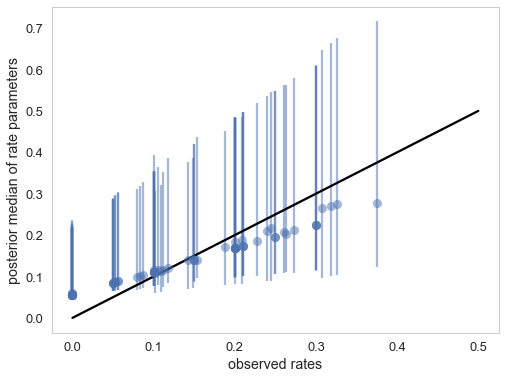

In [34]:
t = rt_traces.get_values('theta')
plt.figure(figsize=(8, 6))
plt.errorbar(tumory/tumorn, np.median(t, axis=0), \
             yerr=[np.percentile(t, 2.5, axis=0), np.percentile(t, 97.5, axis=0)],fmt='o', alpha=0.5);
plt.plot([0, 0.5], [0, 0.5], 'k-');
plt.xlabel('observed rates');
plt.ylabel('posterior median of rate parameters');

#### 2. Explain the shrinkage by comparing against a 45 degree line as done in the lab.

The posterior rates are shrunk towards flatness, which would correspond to complete pooling. Here we put weakly informative hyper-priors on the hyper-parameters, and do a full bayesian analysis. In this case, low sample size experiments (which are statistically weak units) are regularized towards the prior. As a result, we observe the shrinkage.

### Answer to Problem 3 Part D
#### 1. Calculate the marginal posterior of $\theta_{71}$, the "new" experiment.

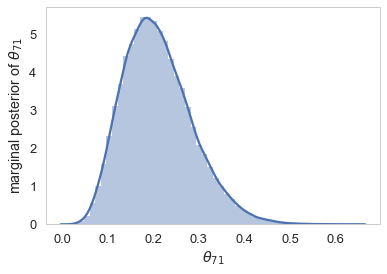

In [35]:
m = rt_traces.get_values('mu')
n = rt_traces.get_values('nu')
a = m / (n * n)
b = (1 - m) / (n * n)

post71 = stats.beta.rvs(a + 4, b + 10)

sns.distplot(post71);
plt.xlabel(r'$\theta_{71}$');
plt.ylabel(r'marginal posterior of $\theta_{71}$');

#### 2. Find the $y_{71}^*$ posterior predictive for that experiment.

/Users/wyssuser/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


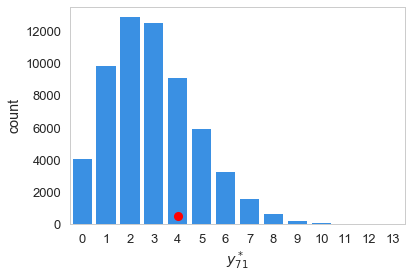

In [36]:
y71 = stats.binom.rvs(14, post71)
sns.countplot(y71, color='#1E90FF');
plt.plot([4], [500], 'ro');
plt.xlabel(r'$y_{71}^*$');